# Convolutional autoencoders

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
#matplotlib inline

In [14]:
mnist = input_data.read_data_sets("MNIST_data/")
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [15]:
# Network Parameters
h_in, w_in = 28, 28 # Image size height and width
k = 3 # Kernel size
p = 2 # pool
s = 2 # Strides in maxpool
filters = {1:32,2:32,3:16}

In [16]:
activation_fn=tf.nn.relu
# Change in dimensions of image after each MaxPool
h_l2, w_l2 = int(np.ceil(float(h_in)/float(s))) , int(np.ceil(float(w_in)/float(s))) 
# Height and width: second encoder/decoder layer
h_l3, w_l3 = int(np.ceil(float(h_l2)/float(s))) , int(np.ceil(float(w_l2)/float(s)))
# Height and width: third encoder/decoder layer

In [17]:
X_noisy = tf.placeholder(tf.float32, (None, h_in, w_in, 1), name='inputs')
X = tf.placeholder(tf.float32, (None, h_in, w_in, 1), name='targets')

In [18]:
### Encoder
conv1 = tf.layers.conv2d(X_noisy, filters[1], (k,k), padding='same',
activation=activation_fn)
# Output size h_in x w_in x filters[1]
maxpool1 = tf.layers.max_pooling2d(conv1, (p,p), (s,s), padding='same')
# Output size h_l2 x w_l2 x filters[1]
conv2 = tf.layers.conv2d(maxpool1, filters[2], (k,k), padding='same',
activation=activation_fn)
# Output size h_l2 x w_l2 x filters[2]
maxpool2 = tf.layers.max_pooling2d(conv2,(p,p), (s,s), padding='same')
# Output size h_l3 x w_l3 x filters[2]
conv3 = tf.layers.conv2d(maxpool2,filters[3], (k,k), padding='same',
activation=activation_fn)
# Output size h_l3 x w_l3 x filters[3]
encoded = tf.layers.max_pooling2d(conv3, (p,p), (s,s), padding='same')
# Output size h_l3/s x w_l3/s x filters[3] Now 4x4x16

In [19]:
### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (h_l3,w_l3))
# Output size h_l3 x w_l3 x filters[3]
conv4 = tf.layers.conv2d(upsample1, filters[3], (k,k), padding='same',
activation=activation_fn)
# Output size h_l3 x w_l3 x filters[3]
upsample2 = tf.image.resize_nearest_neighbor(conv4, (h_l2,w_l2))
# Output size h_l2 x w_l2 x filters[3]
conv5 = tf.layers.conv2d(upsample2, filters[2], (k,k), padding='same',
activation=activation_fn)
# Output size h_l2 x w_l2 x filters[2]
upsample3 = tf.image.resize_nearest_neighbor(conv5, (h_in,w_in))
# Output size h_in x w_in x filters[2]
conv6 = tf.layers.conv2d(upsample3, filters[1], (k,k), padding='same',
activation=activation_fn)
# Output size h_in x w_in x filters[1]

In [22]:
logits = tf.layers.conv2d(conv6, 1, (k,k) , padding='same',activation=None)
# Output size h_in x w_in x 1
decoded = tf.nn.sigmoid(logits, name='decoded')
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [23]:
sess = tf.Session()

In [26]:
epochs = 10
batch_size = 100
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
err = []
for i in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, h_in, w_in, 1))
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={X_noisy: noisy_imgs,X:
        imgs})
        err.append(batch_cost)
        if ii%100 == 0:
            print("Epoch: {0}/{1}... Training loss {2}".format(i, epochs, batch_cost))

Epoch: 0/10... Training loss 0.6767485737800598
Epoch: 0/10... Training loss 0.2225894331932068
Epoch: 0/10... Training loss 0.18781618773937225
Epoch: 0/10... Training loss 0.16971313953399658
Epoch: 0/10... Training loss 0.1496412605047226
Epoch: 0/10... Training loss 0.1478109061717987
Epoch: 1/10... Training loss 0.15006062388420105
Epoch: 1/10... Training loss 0.13435271382331848
Epoch: 1/10... Training loss 0.13160443305969238
Epoch: 1/10... Training loss 0.13606193661689758
Epoch: 1/10... Training loss 0.1342279016971588
Epoch: 1/10... Training loss 0.13157688081264496
Epoch: 2/10... Training loss 0.12997321784496307
Epoch: 2/10... Training loss 0.13353654742240906
Epoch: 2/10... Training loss 0.12536901235580444
Epoch: 2/10... Training loss 0.12705086171627045
Epoch: 2/10... Training loss 0.12004511803388596
Epoch: 2/10... Training loss 0.12642844021320343
Epoch: 3/10... Training loss 0.12064056843519211
Epoch: 3/10... Training loss 0.1204511970281601
Epoch: 3/10... Training lo

Text(0, 0.5, 'Cross Entropy Loss')

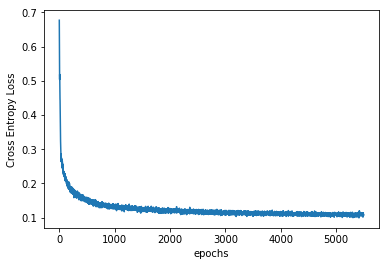

In [27]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')

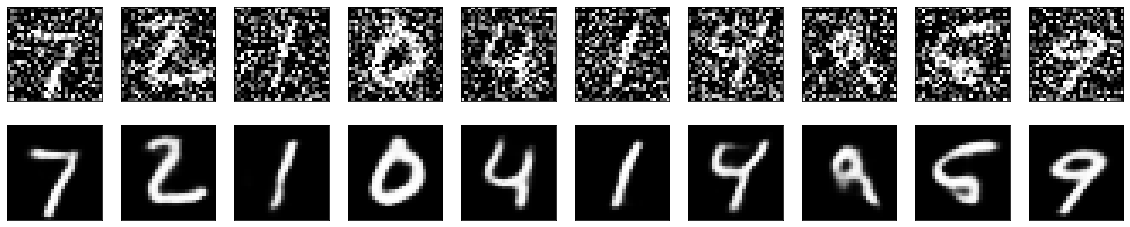

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True,figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
reconstructed = sess.run(decoded, feed_dict={X_noisy:
noisy_imgs.reshape((10, 28, 28, 1))})
for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [34]:
sess.close()